## **障礙物觀點的 puzzle-based reshuffling**

### **集合**
---
$$
\begin{array}{ll}
   T & \text{時間集合，$T = \{1,2,3,...,|T|\}$}  \\
   N & \text{網格格點集合}  \\
   A & \text{格點間路徑集合}  \\
   R & \text{各類推盤集合，$R = \{0,1,2,...,|R|-1\}$}  \\
   \delta^{in}_{ri} & \text{推盤 $r\in R$ 流入格點 $i \in N$ 之節線集合， $\delta^{in}_{ri} \subset A$ } \\
   \delta^{out}_{ri} & \text{推盤 $r\in R$ 流出格點 $i \in N$ 之節線集合， $\delta^{out}_{ri} \subset A$ } \\
   V_i & \text{推盤垂直進出格點 $i \in N$ 之節線集合， $V_i \subset A$ } \\
   H_i & \text{推盤水平進出格點 $i \in N$ 之節線集合， $H_i \subset A$ } \\
\end{array}\\
$$

### **參數**
---

$$
\begin{array}{ll}
   M & \text{極大懲罰數} \\
   \epsilon & \text{極小的數} \\
   S_i^r & \text{推盤 $r\in R$ 初始位置在格點 $i \in N$ 為1；反之為0} \\
   F_i^r & \text{推盤 $r\in R$ 終點位置在格點 $i \in N$ 為1；反之為0} \\
   Num^r & \text{各類推盤 $r \in R$ 數量} \\
   |T| & \text{揀貨時間上限} \\
   P_r & \text{推盤 $r\in R$ 的終點位置，$P_r \in N$} \\
\end{array}\\
$$

### **變數**
---
$$
\begin{array}{ll}
   f^{tr}_{ij} & \text{推盤 $r\in R$ 在時刻 $t \in T$ 自格點 $i \in N$ 移至格點 $j \in N$ 為1；反之為0}  \\
   x^t_r & \text{推盤 $r\in R$ 在時刻 $t \in T$ 抵達終點 $F_i^r$ 為1；反之為0} \\
   w & \text{出貨推盤盤送至揀貨點之最遲時刻，$w \in Integer^+$} \\
\end{array}\\
$$

In [19]:
from gurobipy import *

In [20]:
def print_dict(dict):
    print('{')
    for k, v in dict.items():
        print(f'\t{k}: {v}')
    print('}')
    
def print_2dlist(l):
    print('[')
    for row in l:
        print(f'\t{row}')
    print(']')

In [21]:
# import preprocess_obs  
%run preprocess_obs.ipynb
# import output_obs
%run output_obs.ipynb

### **數學模式**
---
$$
\begin{array}{lll}
   Minimize & w + \epsilon *\displaystyle\sum_{r\in R} \displaystyle\sum_{t\in \{0\} \cup T} \displaystyle\sum_{(i,j) \in A, i \neq j} f^{tr}_{ij}\\
   \\
   Subject \quad To & \\
   \\
   \textbf{流量守恆}\\
   \\
   選一條出去(或沒有) & \displaystyle\sum_{(i,j) \in \delta^{out}_{ri}} f_{ij}^{0r} = S^r_i & \forall i \in N ; r \in R \\
   一條到終點(或沒有) & \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{|T|r} = F^r_i & \forall i \in N ; r \in R \backslash \{0\} \\
   各類推盤守恆 & \displaystyle\sum_{i \in N} \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{|T|r} = Num^r & \forall r \in R \\
   前時刻進=現時刻出 & \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{(t-1)r} = \displaystyle\sum_{(i,j) \in \delta^{out}_{ri}} f_{ij}^{tr} & \forall i \in N ; t \in T ; r \in R \\
    \\
    \textbf{碰撞限制} \\
    \\
    一點一托盤 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{tr} \leq 1 & \forall i \in N ; t \in \{0\} \cup T \\
    不可交換 & \displaystyle\sum_{r \in R} (f_{ji}^{tr} + f_{ij}^{tr}) \leq 1 & \forall i \in N ; (i,j) \in A,i \neq j ; t \in \{0\} \cup T \\
    水平進垂直出 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j_1,i) \in H_i} \displaystyle\sum_{(i,j_2) \in V_i} (f_{j_1i}^{tr} + f_{ij_2}^{tr}) \leq 1 & \forall i \in N ; t \in \{0\} \cup T \\
    垂直進水平出 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j_1,i) \in V_i} \displaystyle\sum_{(i,j_2) \in H_i} (f_{j_1i}^{tr} + f_{ij_2}^{tr}) \leq 1 & \forall i \in N ; t \in \{0\} \cup T \\
    \\
    \textbf{轉向限制} \\
    \\
    水平轉垂直 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j_1,i) \in H_i} f_{j_1i}^{(t-1)r} + \displaystyle\sum_{r \in R} \displaystyle\sum_{(i,j_2) \in V_i} f_{ij_2}^{tr} \leq 1 & \forall i \in N ; t \in T \\
    垂直轉水平 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j_1,i) \in V_i} f_{j_1i}^{(t-1)r} + \displaystyle\sum_{r \in R} \displaystyle\sum_{(i,j_2) \in H_i} f_{ij_2}^{tr} \leq 1 & \forall i \in N ; t \in T \\
    \\
    \textbf{時間限制} \\
    \\
    紀錄進入終點時刻 & \displaystyle\sum_{(j, P_r) \in A} f^{(t-1)r}_{jP_r} \geq x^t_r & \forall t \in T ; r \in R \backslash \{0\} \\
    離開終點的節線 & \displaystyle\sum_{(P_r, j) \in A} f^{tr}_{P_rj} \geq x^t_r & \forall t \in \{0\} \cup T ; r \in R \backslash \{0\} \\
    紀錄進入終點時刻 & x^{|T|}_r \geq 1 & r \in R \backslash \{0\} \\
    至少經過終點一次 & \displaystyle\sum_{t \in \{0\} \cup T} x^t_r \geq 1 & \forall r \in R \backslash \{0\} \\
    最遲抵達終點時刻 & (t * x^t_r) \leq w & \forall t \in \{0\} \cup T ; \forall r \in R \backslash \{0\} \\
    \\
    \textbf{時間限制} \\
    \\
    紀錄進入終點時刻 & \displaystyle\sum_{(j, P_r) \in A, j \neq P_r} f^{tr}_{jP_r} \leq x^t_r & \forall t \in \{0\} \cup T ; r \in R \backslash \{0\} \\
    最遲抵達終點時刻 & (t+1) * x^t_r \leq w & \forall t \in \{0\} \cup T ; \forall r \in R \backslash \{0\} \\
    \\
    Bound & \\
          & f^{tr}_{ij} \in \{0,1\} & \forall r \in R ; (i,j) \in A ; t \in \{0\} \cup T \\
          & x^t_r \in \{0,1\} & \forall r \in R \backslash \{0\} ; t \in \{0\} \cup T\\
          & w \in Z^+ \\
    \\
\end{array}\\            
$$

In [28]:
def runModelObs(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num):
    model = Model("Puzzle-Based Reshuffling")
    
    f = {}
    x = {}
    w = 0
    for t in [0]+T:
        for r in R:
            x[t,r] = model.addVar(vtype = "B", name = "x(%d,%d)" % (t,r))
            for i in N:
                for j in N:
                    f[t,r,i,j] = model.addVar(vtype = "B", name = "f(%d,%d,%d,%d)" % (t,r,i,j))
                    # x[t,r] = model.addVar(vtype = "B", name = "x(%d,%d)" % (t,r))
    
    w = model.addVar(vtype = "I", name = "w")
    
    for r in R:
        for i in N:
            # 時間 0，所有貨物 r 從起點出發遵守流量守恆
            model.addConstr(quicksum(f[0, r, i, j[1]] for j in Out_ri[i]) == S_ri[r][i], name = f"Start_R{r}_N{i}")
            # 時間 T，所有貨物 r 抵達終點遵守流量守恆
            if r != 0:
                model.addConstr(quicksum(f[T_ub, r, j[1], i] for j in In_ri[i]) == F_ri[r][i], name = f"End_R{r}_N{i}")
            # 所有相鄰時刻，同個點同個貨物要有一進一出
            for t in T:
                model.addConstr(quicksum(f[t-1, r, j[1], i] for j in In_ri[i]) == quicksum(f[t, r, i, j[1]] for j in Out_ri[i]),
                                name = f"Flow_balance_T{t}_R{r}_N{i}")
                
    # 時間 T，所有推盤類別 r 抵達終點，且同類推盤總和遵守流量守恆
    # for r in R:
    #     model.addConstr(quicksum(f[T_ub, r, j[1], i] for i in N for j in In_ri[i]) == Num[r], name = f"End_R{r}")

    # 其實可以改成 only for 障礙物
    model.addConstr(quicksum(f[T_ub, 0, j[1], i] for i in N for j in In_ri[i]) == Num[0], name = f"End_R0")
                
    for t in [0]+T:
        for i in N:
            # 一個格點只能有一個貨物
            model.addConstr(quicksum(quicksum(f[t, r, j[1], i] for j in In_ri[i]) for r in R) <= 1, 
                            name = f"Grid_{i}_Limit_in_time_{t}")
            # 禁止交換
            for j in A:
                if i != j[1]:
                    model.addConstr(quicksum((f[t, r, j[1], i] + f[t, r, i, j[1]]) for r in R) <= 1, 
                                    name = f"No_swapped_{i}_{j[1]}")
            # 同時刻的進出方向不能交錯
            model.addConstr(quicksum(f[t, r, j1[1], i] for j1 in Hi[i] for r in R) + 
                            quicksum(f[t, r, i, j2[1]] for j2 in Vi[i] for r in R) <= 1,
                            name = f"H{i}_in_V{i}_out")
            model.addConstr(quicksum(f[t, r, j1[1], i] for j1 in Vi[i] for r in R) + 
                            quicksum(f[t, r, i, j2[1]] for j2 in Hi[i] for r in R) <= 1,
                            name = f"V{i}_in_H{i}_out")
            
    for t in T:
        for i in N:
            # 轉向限制停留 1 單位時間
            model.addConstr(quicksum(f[t-1, r, j1[1], i] for j1 in Hi[i] for r in R) + 
                            quicksum(f[t, r, i, j2[1]] for j2 in Vi[i] for r in R) <= 1,
                            name = f"H{i}_turn_V{i}")
            model.addConstr(quicksum(f[t-1, r, j1[1], i] for j1 in Vi[i] for r in R) + 
                            quicksum(f[t, r, i, j2[1]] for j2 in Hi[i] for r in R) <= 1,
                            name = f"V{i}_turn_H{i}")


    for t in [0]+T:
        for r in R[1:]:
            for endpos in P:
                if endpos[0] == r:
                    model.addConstr(quicksum(f[t, r, j[1], endpos[1]] for j in In_ri[endpos[1]] if j[1] != endpos[1]) <= 
                                    x[t, r] , name = f"Record_T{t}_R{r}")
                    
    for t in [0]+T:
        for r in R[1:]:
            model.addConstr( (t+1)*x[t,r] <= w, name = f"Time_Limit_R{r}")    
    

    
    A_neq = []
    for arc in A:
        if arc[0] != arc[1]:
            A_neq.append(arc)
    
    is_running = False
    timelimit = 500
    model.Params.LogtoConsole = is_running  # 是否列出軟體求解過程
    model.Params.timeLimit = timelimit      # 求解時限
    model.setObjective(w + epsilon * quicksum(f[t,r,i,j] for t in [0]+T for r in R for (i,j) in A_neq) , GRB.MINIMIZE)
    model.setParam('MIPFocus', 2)  # 專注於提高下界
    model.optimize()

    return model



In [29]:
def runAnalyzeModelObs(model, map_start, size, T, R, A):
    if model.status == GRB.OPTIMAL:
        model.write("model_obs.lp")      # 可行約束條件
        # Print Optimal value and solution
        printModel(model, map_start, size, T, R, A)
        return model.Runtime, model.objVal
    
    elif model.status == GRB.TIME_LIMIT:
        print("Time out, cannot get a optimal solution")
        print('-' * 40)
        return model.Params.timeLimit, 0
        
    elif model.status == GRB.INFEASIBLE:
        model.computeIIS()
        model.write("model_obs.ilp")   # 寫出不可行的約束條件
        print("Infeasible, no solution found.")
        print('-' * 40)
        return 0, 0

In [30]:
# 測試單一測資
# main test

# MIPFocus = 0, time = 6.858000040054321
# MIPFocus = 1, time = 20.997999906539917
# MIPFocus = 2, time = 6.663000106811523
# MIPFocus = 3, time = 6.937000036239624
# size = (3,3)
# n_sp = 4
# n_tar = 3
# id = 1
# ####################
size = (3,3)
n_sp = 3
n_tar = 3
id = 6
# size = (2,3)
# n_sp = 2
# n_tar = 2
# id = 3


map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num = preprocess(size, n_sp, n_tar, id)
model = runModelObs(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num)
runtime, obj = runAnalyzeModelObs(model, map_start, size, T, R, A)
os.makedirs(f'result_graphform/model_obs/{size[0]}x{size[1]}/tar{n_tar}', exist_ok=True)
fp = f'result_graphform\\model_obs\\{size[0]}x{size[1]}\\tar{n_tar}\\graph_result_{size[0]}x{size[1]}_tar{n_tar}_sp{n_sp}_{id}.txt'
writeModel(model, map_start, fp, size, T, R, A)
print_2dlist(map_end)

# 記得之後要加 MIPGap
# 也要加上問題設定的時間 (time)
print(model.MIPGap)

running time =  0.33299994468688965
optimal value =  5.011
----------------------------------------
[
	[1, -1, 3]
	[-1, 0, 2]
	[-1, 0, 0]
]
0.0


In [27]:
# run all graphform
import csv
import os
import math

def writeResultCSV(size):
    s = size
    
    datadict, tar_list = pairDataDict(size)

    folder = 'result/model_obs'
    os.makedirs(folder, exist_ok=True)
    
    with open(f'result/model_obs/obs_{size[0]}x{size[1]}.csv', 'w') as f:
        w = csv.writer(f)
        w.writerow(['n_tar', 'n_sp', 'id', 'Runtime', 'Obj'])
        for n_tar, spacelist in datadict.items():
            os.makedirs(f'result_graphform/model_obs/{size[0]}x{size[1]}/tar{n_tar}', exist_ok=True)
            # 註：if 條件用來控制跑什麼測資
            for n_sp in spacelist:
                num = 10
                if s[0] == 3 and s[1] == 3:
                    if n_tar == 1 and n_sp == 8: num = 9
                    elif n_sp == 1: num = 9
                if s[0] >= 5: num = 5
                for id in range(num):    # 0~num-1
                    map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num = preprocess(size, n_sp, n_tar, id)
                    model = runModelObs(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num)
                    runT, runObj = runAnalyzeModelObs(model, map_start, size, T, R, A)
                    # 把個別結果寫到檔案
                    file_path = f'result_graphform\\model_obs\\{size[0]}x{size[1]}\\tar{n_tar}\\graph_result_{size[0]}x{size[1]}_tar{n_tar}_sp{n_sp}_{id}.txt'
                    writeModel(model, map_start, file_path, size, T, R, A)
                    # 記得處理 timeout 和 infeasible
                    w.writerow([n_tar, n_sp, id, round(runT, 3), runObj])
                # runT, runObj = runModelObs(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num)


In [25]:
# 這邊是引入 output_obs 來做
# main

size = (3,3)
datadict, tar_list = pairDataDict(size)
print(datadict)

{1: [2, 3, 4, 5, 6, 8], 2: [2, 3, 4, 5, 6, 7], 3: [2, 3, 4, 5, 6], 4: [2, 3, 4, 5], 5: [2, 3, 4], 6: [2, 3]}


In [17]:
# 這行是跑所有測資，會非常久（註：之後要考慮加上 os 來判斷檔案是否存在）
writeResultCSV(size)

running time =  0.18399977684020996
optimal value =  4.009
----------------------------------------
running time =  3.385999917984009
optimal value =  7.01
----------------------------------------
running time =  3.2880001068115234
optimal value =  6.016
----------------------------------------
running time =  2.075000047683716
optimal value =  7.016
----------------------------------------
running time =  0.9169998168945312
optimal value =  5.009
----------------------------------------
running time =  2.242000102996826
optimal value =  6.011
----------------------------------------
running time =  0.15899991989135742
optimal value =  4.005
----------------------------------------
running time =  3.9600000381469727
optimal value =  7.013
----------------------------------------
running time =  3.4839999675750732
optimal value =  6.017
----------------------------------------
running time =  4.538000106811523
optimal value =  7.011
----------------------------------------
running time 

-----new_dict----
{
	1: {2: 0.198, 3: 0.11, 4: 0.108, 5: 0.116, 6: 0.116, 8: 0.061}
	2: {2: 0.738, 3: 0.282, 4: 0.209, 5: 0.19, 6: 0.196, 7: 0.117}
	3: {2: 3.06, 3: 0.406, 4: 0.394, 5: 0.224, 6: 0.195}
	4: {2: 7.912, 3: 1.548, 4: 0.83, 5: 0.28}
	5: {2: 10.499, 3: 1.733, 4: 0.824}
	6: {2: 23.013, 3: 6.221}
}
{
	1: {2: 3.906, 3: 3.103, 4: 3.103, 5: 3.003, 6: 2.502, 8: 2.224}
	2: {2: 4.307, 3: 3.905, 4: 3.806, 5: 3.404, 6: 3.504, 7: 3.804}
	3: {2: 6.912, 3: 4.808, 4: 4.908, 5: 4.207, 6: 4.506}
	4: {2: 7.514, 3: 6.411, 4: 5.709, 5: 4.708}
	5: {2: 8.115, 3: 6.111, 4: 5.711}
	6: {2: 8.616, 3: 7.815}
}


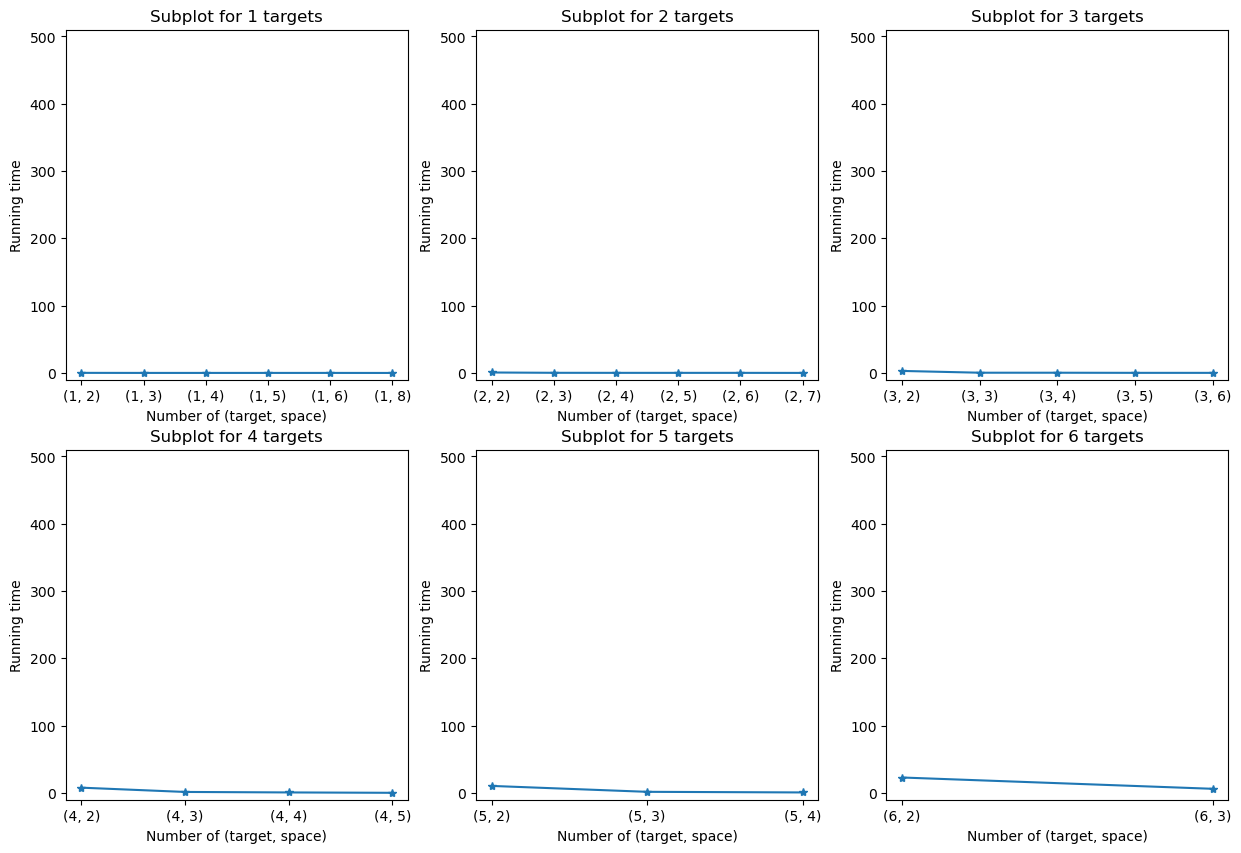

In [69]:
resultGraph(size, datadict, tar_list)
# os.makedirs('./result/model_obs_chart_summary/', exist_ok=True)
# plt.savefig(f'./result/model_obs_chart_summary/{size[0]}x{size[1]}_turn.png')

In [26]:
# 檢查結果

arr = []
for n_tar, spacelist in datadict.items():
    for n_sp in spacelist:
        num = 10
        if size[0] == 3 and size[1] == 3:
            if n_tar == 1 and n_sp == 8: num = 9
            elif n_sp == 1: num = 9
        if size[0] >= 5: num = 5
        for id in range(num):    # 0~num-1
            map_end = []
            result = []
            T_ub = 0
            with open(f"data_graphform\\{size[0]}x{size[1]}\\tar{n_tar}\\end\\graph_end_{size[0]}x{size[1]}_tar{n_tar}_sp{n_sp}_{id}.txt", "r") as file_end:
                T_ub = int(file_end.readline())
                for line in file_end.readlines():
                    map_end += [list(map(int, line.split(',')))]
            check = checkModel(model, T_ub, map_end, size, n_tar, n_sp, id)
            arr.append(check)
print(sum(arr))

259
